In [1]:
"""Showcase a PDF-based Brownian coagulation example.

Builds a lognormal PDF aerosol, configures Brownian coagulation with
``distribution_type="continuous_pdf"``, runs multiple steps, and plots PDF
concentration before/after execution to visualize redistribution. Uses a
continuous probability density function representation where units are
number per volume per size (m^-3 * m^-1 = m^-4).

Example:
    Run the script to generate before/after concentration curves for a
    continuous PDF aerosol using the public ``par.dynamics`` API.
"""

'Showcase a PDF-based Brownian coagulation example.\n\nBuilds a lognormal PDF aerosol, configures Brownian coagulation with\n``distribution_type="continuous_pdf"``, runs multiple steps, and plots PDF\nconcentration before/after execution to visualize redistribution. Uses a\ncontinuous probability density function representation where units are\nnumber per volume per size (m^-3 * m^-1 = m^-4).\n\nExample:\n    Run the script to generate before/after concentration curves for a\n    continuous PDF aerosol using the public ``par.dynamics`` API.\n'

# Coagulation Pattern 2: PDF

Brownian coagulation using the public `par.dynamics` API with a
continuous PDF representation:

1. Build a Brownian coagulation strategy with
   `distribution_type="continuous_pdf"`.
2. Wrap it in `par.dynamics.Coagulation`.
3. Run multiple steps on a PDF aerosol and visualize the change.

In [2]:
# In Colab uncomment the following command to install particula:
#!pip install particula[extra] --quiet
import matplotlib.pyplot as plt
import numpy as np
import particula as par

## Build a PDF aerosol

We create a lognormal PDF and attach it to an ambient atmosphere. PDF units
are m^-3 * m^-1 = m^-4 (number per volume per size).

In [3]:
# Radius bins (log-spaced, extended to 10 microns for visibility)
radius_bins = np.logspace(-8, -5, 150)  # m (10 nm to 10 um)

# Lognormal PDF (concentration per unit size) - high concentration for effect
concentration_pdf = par.particles.get_lognormal_pdf_distribution(
    x_values=radius_bins,
    mode=np.array([80e-9]),
    geometric_standard_deviation=np.array([1.5]),
    number_of_particles=np.array(
        [1e10]
    ),  # m^-3 total (increased for visibility)
)

# Atmosphere (ambient, non-condensing)
atmosphere = (
    par.gas.AtmosphereBuilder()
    .set_temperature(25, "degC")
    .set_pressure(1, "atm")
    .build()
)

# PDF particle representation
particles_pdf = (
    par.particles.PresetParticleRadiusBuilder()
    .set_distribution_type("pdf")
    .set_radius_bins(radius_bins, radius_bins_units="m")
    .set_concentration(concentration_pdf, concentration_units="m^-3")
    .set_density(np.array([1_000.0]), density_units="kg/m^3")
    .set_charge(np.zeros_like(radius_bins))
    .build()
)

# Aerosol object
pdf_aerosol = par.Aerosol(atmosphere=atmosphere, particles=particles_pdf)

## Configure coagulation (continuous PDF)

Use the Brownian builder with `distribution_type="continuous_pdf"`, then wrap
in the public `Coagulation` runnable.

In [4]:
coagulation_strategy = (
    par.dynamics.BrownianCoagulationBuilder()
    .set_distribution_type("continuous_pdf")
    .build()
)
coagulation_process = par.dynamics.Coagulation(
    coagulation_strategy=coagulation_strategy
)

print(coagulation_process)

## Execute coagulation steps

Run two coagulation steps to observe the evolution of the PDF distribution
over time.

In [5]:
# Set up time and sub-steps for the coagulation process
# Longer time span for visible coagulation effect
time_step = 3600  # 1 hour per step
sub_steps = 100

radii = pdf_aerosol.particles.get_radius()
pdf_before = np.copy(pdf_aerosol.particles.concentration)

# Perform coagulation process for step 1
pdf_aerosol = coagulation_process.execute(
    pdf_aerosol, time_step=time_step, sub_steps=sub_steps
)
radii_after_step_1 = pdf_aerosol.particles.get_radius()
pdf_after_step_1 = np.copy(pdf_aerosol.particles.concentration)

# Perform coagulation process for step 2
pdf_aerosol = coagulation_process.execute(
    pdf_aerosol, time_step=time_step, sub_steps=sub_steps
)
radii_after_step_2 = pdf_aerosol.particles.get_radius()
pdf_after_step_2 = np.copy(pdf_aerosol.particles.concentration)

## Plot: concentration before/after

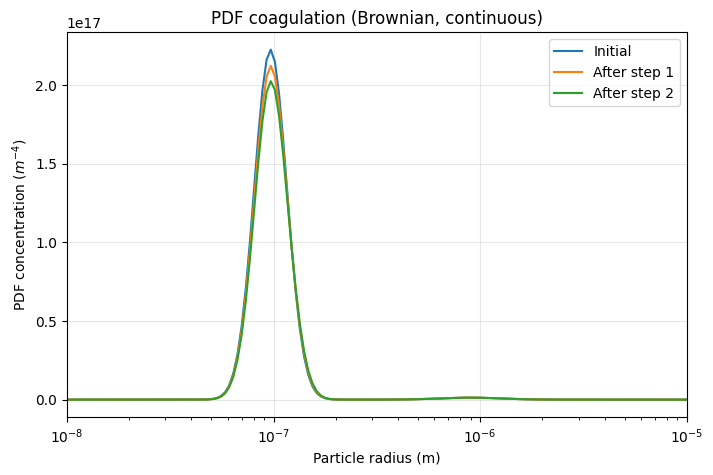

In [6]:
fig, ax = plt.subplots(figsize=(8, 5))
ax.plot(radii, pdf_before, label="Initial", color="tab:blue")
ax.plot(
    radii_after_step_1,
    pdf_after_step_1,
    label="After step 1",
    color="tab:orange",
)
ax.plot(
    radii_after_step_2,
    pdf_after_step_2,
    label="After step 2",
    color="tab:green",
)
ax.set_xscale("log")
ax.set_xlim(1e-8, 1e-5)  # 10 nm to 10 um
ax.set_xlabel("Particle radius (m)")
ax.set_ylabel(r"PDF concentration ($m^{-4}$)")
ax.set_title("PDF coagulation (Brownian, continuous)")
ax.legend()
ax.grid(alpha=0.3)
plt.show()

## Summary

- Strategy: `BrownianCoagulationBuilder().set_distribution_type(
  "continuous_pdf")`
- Runnable: `par.dynamics.Coagulation`
- Representation: PDF (continuous number concentration per size, m^-4)